In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import solve_ivp
from datetime import datetime
import scipy.io


In [193]:
read_file = pd.read_csv ('Dados_novos_BAHIA.csv')

Psi = scipy.io.loadmat('Psi_Ba13set.mat')
# get psy second index
Psi = list(Psi.values())[3]
flat_Psi = [x for xs in Psi for x in xs]
npd = len(Psi)
Nfo = 8
for k in range(1, npd):
    if (k-Nfo) < 0:
        flat_Psi[k] = 1/k*sum(Psi[1:k])
    else:
        flat_Psi[k] = 1/Nfo*sum(Psi[k-Nfo+1:k])

firstTwo = flat_Psi[:2]
rest = flat_Psi[2:]

flat_Psi = firstTwo + [x for xs in rest for x in xs]

In [194]:
Data = read_file['datetime']
# parse data to datetime
Data = [datetime.strptime(x, '%Y-%m-%d') for x in Data]

CasosAcumuladosDados = read_file['Casos acumulados'].fillna(0)
CasosAcumuladosDados = CasosAcumuladosDados/14930634
# print(CasosAcumuladosDados.to_string())

RecuperadosDados = read_file['Recuperados'].fillna(0)
RecuperadosDados = RecuperadosDados/14930634
# print(RecuperadosDados.to_string())

MortosDados = read_file['Mortos'].fillna(0)
MortosDados = MortosDados/14930634
# print(MortosDados.to_string())

HospitalizadosDados = read_file['Hospitalizados'].fillna(0)
HospitalizadosDados = HospitalizadosDados/14930634
# print(HospitalizadosDados.to_string())

UTIDados = read_file['UTI'].fillna(0)
UTIDados = UTIDados/14930634
# print(UTIDados.to_string())

VacinadosDados = read_file['Vacinados'].fillna(0)
VacinadosDados = VacinadosDados/14930634
# print(VacinadosDados.to_string())

In [195]:
def F(t, y, flat_Psi):
    psi=flat_Psi[int(t)]

    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v=0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2



    if t<20.178:
        beta=2.1317;    
    elif (t>=28.178-8) and (t< 72.94):
        beta=1.7645;    
    elif (t>=72.94) and (t< 148):
        beta=1.1281
    else:
        beta=1

    # tau is the rate of vaccination
    # tau = VacinadosDados.diff().fillna(0)

    beta_v = beta/2

    if t<19:
        tau=0;
        delta_av = 0;
        delta_sv = 0;
        phi_e = 0;
        k_v=0;
        p_v = 0;
        gamma_av = 0;
        gamma_sv = 0;
        gamma_vu=0;
        qsi_v = 0 ;
        eps=0;
        mi_vh=0;
        mi_vu=0;
        gamma_vh=0; 
        gamma_vh=0.36;
    else:
        delta_av = 0.31;
        delta_sv = 0.31;
        phi_e = 0.07;
        k_v=1/3;
        p_v = 0.1;
        gamma_av = 1/3.5;
        gamma_sv = 1/4;
        gamma_vu=0.26;
        qsi_v = 0.99;
        eps=0.7;
        mi_vh=0.03;
        mi_vu=0.08;
        gamma_vh=0.36;

    tau = VacinadosDados.diff().fillna(0)[int(t)]
    N = 14930634
    S=y[0]
    E=y[1]
    Sv=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    Hv=y[9]
    U=y[10]
    Uv=y[11]
    R=y[12]
    Rv=y[13]
    D=y[14]
    Nw=y[15]
    NwV=y[16]
    
    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau;
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E;
    dSvdt = tau - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv;
    dEvdt = (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev;
    dIadt = (1-p)*k*E - gamma_a*Ia;
    dIsdt = p*k*E - gamma_s*Is;
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav;
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv;
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H;
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vu*Hv;
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U;
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_h*Hv - gamma_u*Uv;
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H - phi_e*eps*Sv;
    dRvdt = gamma_av*Iav + (1-h)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv);
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_h)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv);
    dNwdt = p*k*E + p_v*k_v*Ev;
    dNwVdt = tau;
    
    return [dSdt, dEdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]

seiihurd = lambda t, s: F(t, s, flat_Psi)


In [196]:
D0          = 9159/14930634
N0          = 1
R0          = 451240/14930634
H0          = 477/14930634
HV0         = 0
U0          = 737/14930634
UV0         = 0
V0          = 0
Rv0         = 0
Is0         = (494684 - 451240)/14930634
Ia0         = Is0*0.9/14930634
Iav0        = 0
Isv0        = 0
E0          = (518955 - 494684)/14930634
Ev0         = 0
S0          = (N0-Is0-Ia0-E0)/14930634
Nw0         = 0
NwV0        = 0
Model_0     = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,HV0,U0,UV0,R0,Rv0,D0,Nw0,NwV0]
ts0=np.arange(148)
sol = solve_ivp(seiihurd, [0,148], Model_0, vectorized=False, max_step=1000000, t_eval=ts0)

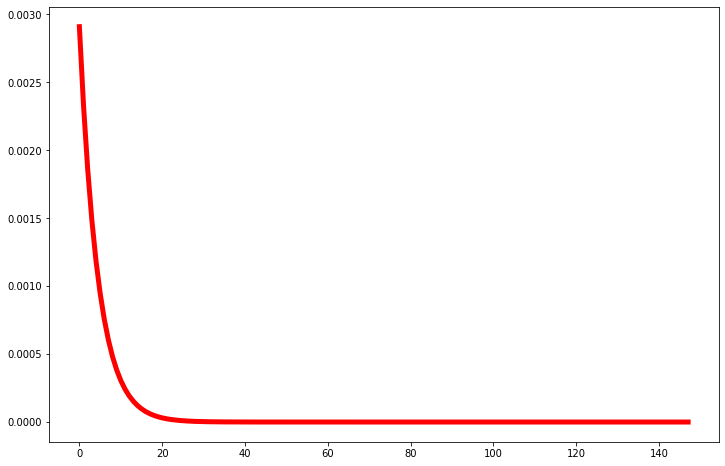

In [197]:
casos = sol.y[-2]
casosDiff = casos[:147]
# plot the model
ts1=np.arange(148)
fig, ax = pl.subplots(figsize=(12,8))
sintomaticos_curva =  sol.y[5]+ sol.y[7]

ax.plot(ts1, sintomaticos_curva, color='r',zorder=1, linewidth=5)
# ax.scatter(ts1, CasosAcumuladosDados[:147], color='g',zorder=1, linewidth=5)

# VERMELHO É O MODELO E VERDE É O DADO